In [1]:
"""
Modeling utilizing MTheory feature engineering 
""";

In [2]:
import MTheory as mt
import imlearn
import IREP

In [3]:
import numpy as np
import pandas as pd
import collections
import os
import time
import pickle

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [63]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm, decomposition
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

In [6]:
import librosa
import librosa.display

In [7]:
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')

In [8]:
main_path = '/Users/ilanmoscovitz/github/sf18_ds11/projects/03-mcnulty/Music/'

music_universe = {'Bach': ['Art_of_Fugue','Goldberg_Variations','Partitas','Sinfonia','Two_Part_Inventions','WTC1','WTC2','Other'],
                  'Mozart': ['Sonatas','Sonatinas','Fugue','Variations','Other']}

df_filename = '/Users/ilanmoscovitz/github/sf18_ds11/projects/03-mcnulty/Raw_Arrays.pkl'
extraction_keys = ['y','sr','y_harmonic','y_percussive','chroma', 'sparse']
examples_path = main_path + 'Samples/'

In [9]:
def add_example(df, sample, sample_path):
    
    # Collect extractions
    y = sample.base['y']
    sr = sample.base['sr']
    chroma = sample.base['chroma']

    # Idee
    idee = {'Composer':sample.idee['Composer'],
            'Collection':sample.idee['Collection'],
            'Song':sample.idee['Song'],
            'Snippet':sample.idee['Snippet']}
    
    # Generate intervalic features
    interval_strengths = sample.interval_summary()
    interval_classes = sample.interval_class_summary()
    poly_mean = sample.mean_polyphony()
    poly_var = sample.var_polyphony()
    
    # Generate harmonic features
    sample.try_build_tonality_matches()
    mode = sample.mode
    tonal_clarity = sample.tonal_clarity
    tonal_distance = sample.try_build_dist_from_parent_tonality()
    
    # Save Sample's updated harmonic computation
    sample.to_pickle(sample_path)
    
    # Add features to df
    features = {'Poly_mean':poly_mean,
                'Poly_var':poly_var,
                'Mode':mode,
                'Tonal_Clarity':tonal_clarity,
                'Tonal_Distance':tonal_distance} 

    intervals = [('Interval_'+str(i)) for i in list(range(1,7))]
    features.update(dict(zip(intervals, interval_strengths)))
    
    interval_class_names = ['Dissonance','Consonance','Perfect']
    features.update(dict(zip(interval_class_names, interval_classes)))
                
    #parent_path = main_path+'/'+composer+'/'+collection+
    
    to_add = idee.copy()
    to_add.update(features)
    df = df.append(to_add, ignore_index=True)

    return df

In [10]:
def cols_to_front(df, front_cols):
    cols = list(df)
    for col in reversed(front_cols):
        cols.insert(0, cols.pop(cols.index(col)))
    return df[cols]

In [11]:
def elapsed(end,start):
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    seconds=int(seconds)
    
    result = ''
    if hours: result += str(int(hours))+':'
    if minutes: 
        result += str(int(minutes))+':'
    else:
        result = ':'
    result+=str(seconds)
    
    return result

In [12]:
def make_df(examples_path):
    df = pd.DataFrame()
    sample_filenames = os.listdir(examples_path)
    
    start_time = time.time()
    count = 1
    for sample_filename in sample_filenames:
        current_time = time.time()
        if 'example' in sample_filename: 
            sample = mt.get_pickle(examples_path+sample_filename)
            df = add_example(df, sample, examples_path+sample_filename)
        if not count%100: 
            print('Example', count, 'of', len(sample_filenames),elapsed(current_time,start_time))
        count+=1
        
    front_cols = ['Composer', 'Collection', 'Song', 'Snippet']
    df = cols_to_front(df, front_cols)
    
    end_time = time.time()
    print('\ntotal minutes:',elapsed(end_time,start_time))
    
    return df

In [13]:
#df = make_df(examples_path)

In [14]:
#df.head()

In [15]:
# Numericize Mode feature
#df['Mode'] = df['Mode'].map(lambda x: 0 if x=='Major' elif x=='Minor' 1)

In [16]:
#df.head()

In [17]:
#df[df.isnull().any(axis=1)]

In [18]:
#df = df.dropna()

In [19]:
# Pickle it
#pickle.dump(df,open('MT_Feature_df.pkl','wb'))

In [20]:
df = pd.read_pickle('MT_Feature_df.pkl')

In [21]:
# Custom train-test split
train, test = imlearn.custom_train_test_split(df, 'Song', test_size=0.3, random_seed=50)

In [22]:
# Hide cheating attributes during training
omit_mask = ['Collection','Song','Snippet']

In [23]:
# Train using CustomGridCV

models = [('svm',svm.SVC),
          ('knn', KNeighborsClassifier), 
          ('logistic', LogisticRegression),
          ('tree', DecisionTreeClassifier),
          ('forest', RandomForestClassifier)
         ]

param_choices = [
    {
        'kernel': ['rbf'],
        'C': np.logspace(-3,3,6),
        'gamma': np.logspace(-3,3,6)
    },
    {
        'n_neighbors': range(1, 12)
    },
    {
        'C': np.logspace(-3,6, 12),
        'penalty': ['l1', 'l2']
    },
    {
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    },
    {
        'n_estimators': [50, 100, 200],
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    }
]

grids = {}
grid_predictions = {}
grid_actuals = {}

for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = imlearn.CustomGridCV(clf=model(), params=params, fold_on='Song') # CustomGridCV defaults to standard scaling
    grid.fit_score(train, y_feat='Composer', omit_mask=omit_mask, random_seed=42, display=False)
    s = f"{name}: best score: {grid.best_score_}"
    p = f"{name}: best params: {grid.best_parameters_}"
    print(s)
    print(p)
    print()
    grids[name] = grid
    grid_predictions[name],grid_actuals[name] = grid.best_predictions_actuals_

svm: best score: 0.6454787751260472
svm: best params: {'C': 1000.0, 'gamma': 3.981071705534969, 'kernel': 'rbf'}

knn: best score: 0.6233781125972597
knn: best params: {'n_neighbors': 1}

logistic: best score: 0.6585480555884795
logistic: best params: {'C': 151991.10829529332, 'penalty': 'l1'}

tree: best score: 0.6588379721829375
tree: best params: {'max_depth': 4, 'min_samples_leaf': 10}

forest: best score: 0.6539346724567714
forest: best params: {'max_depth': 5, 'min_samples_leaf': 3, 'n_estimators': 200}



In [24]:
# Check off-the-grids

models = [
          ('tree', DecisionTreeClassifier),
          ('forest', RandomForestClassifier)
         ]

param_choices = [
    {
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10,13,16,20]
    },
    {
        'n_estimators': [50, 100, 200],
        'max_depth': [1,2,3,4,5,6,7,8,9,10],
        'min_samples_leaf': [3,6,10]
    }
]

grids2 = {}
grid_predictions = {}
grid_actuals = {}

for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = imlearn.CustomGridCV(clf=model(), params=params, fold_on='Song') # CustomGridCV defaults to standard scaling
    grid.fit_score(train, y_feat='Composer', omit_mask=omit_mask, random_seed=42, display=False)
    s = f"{name}: best score: {grid.best_score_}"
    p = f"{name}: best params: {grid.best_parameters_}"
    print(s)
    print(p)
    print()
    grids2[name] = grid
    grid_predictions[name],grid_actuals[name] = grid.best_predictions_actuals_

tree: best score: 0.6596006264139683
tree: best params: {'max_depth': 4, 'min_samples_leaf': 16}

forest: best score: 0.6995983506867153
forest: best params: {'max_depth': 10, 'min_samples_leaf': 6, 'n_estimators': 200}



In [ ]:
# Best models with MTheory
"""
svm: best score: 0.6454787751260472
svm: best params: {'C': 1000.0, 'gamma': 3.981071705534969, 'kernel': 'rbf'}

knn: best score: 0.6233781125972597
knn: best params: {'n_neighbors': 1}

logistic: best score: 0.6584923044805571
logistic: best params: {'C': 151991.10829529332, 'penalty': 'l1'}
        
tree: best score: 0.6596006264139683
tree: best params: {'max_depth': 4, 'min_samples_leaf': 16}

forest: best score: 0.7035600485439406
forest: best params: {'max_depth': 10, 'min_samples_leaf': 6, 'n_estimators': 100}
""";

In [23]:
# Round 2 greater resolution

models = [('svm',svm.SVC),
          ('knn', KNeighborsClassifier), 
          ('tree', DecisionTreeClassifier),
          ('forest', RandomForestClassifier)
         ]

param_choices = [
    {
        'kernel': ['rbf'],
        'C': np.linspace(100,10000,10),
        'gamma': np.logspace(1,10,10)
    },
    {
        'n_neighbors': [1]
    },
    {
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [13,14,15,16,17,18,19,10]
    },
    {
        'n_estimators': [75, 100, 125],
        'max_depth': [9,10,11,13,15],
        'min_samples_leaf': [4,5,6,7,8,9,10]
    }
]

grids3 = {}
grid_predictions = {}
grid_actuals = {}

for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = imlearn.CustomGridCV(clf=model(), params=params, fold_on='Song') # CustomGridCV defaults to standard scaling
    grid.fit_score(train, y_feat='Composer', omit_mask=omit_mask, random_seed=42, display=False)
    s = f"{name}: best score: {grid.best_score_}"
    p = f"{name}: best params: {grid.best_parameters_}"
    print(s)
    print(p)
    print()
    grids3[name] = grid
    grid_predictions[name],grid_actuals[name] = grid.best_predictions_actuals_

svm: best score: 0.6261236901178762
svm: best params: {'C': 100.0, 'gamma': 10.0, 'kernel': 'rbf'}

knn: best score: 0.6233781125972597
knn: best params: {'n_neighbors': 1}

tree: best score: 0.6606644562012024
tree: best params: {'max_depth': 4, 'min_samples_leaf': 16}

forest: best score: 0.7038191591067667
forest: best params: {'max_depth': 13, 'min_samples_leaf': 4, 'n_estimators': 125}



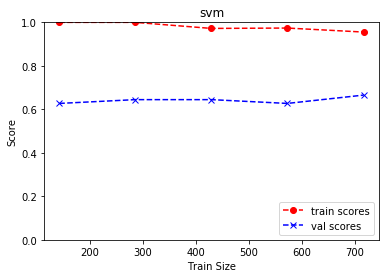

In [29]:
imlearn.draw_learning_curve(train, y_feat='Composer', split_on='Song', clf=grids3['svm'].best_model_, cv=5, omit_mask=omit_mask, random_seed=42, title="svm")

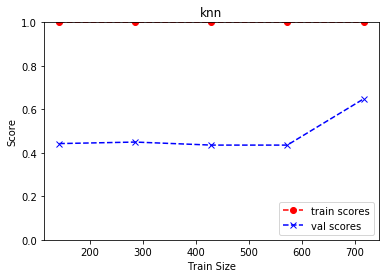

In [30]:
imlearn.draw_learning_curve(train, y_feat='Composer', split_on='Song', clf=grids3['knn'].best_model_, cv=5, omit_mask=omit_mask, random_seed=42, title="knn")

In [31]:
imlearn.draw_learning_curve(train, y_feat='Composer', split_on='Song', clf=grids['logistic'].best_model_, cv=5, omit_mask=omit_mask, random_seed=42, title="logistic")

NameError: name 'grids' is not defined

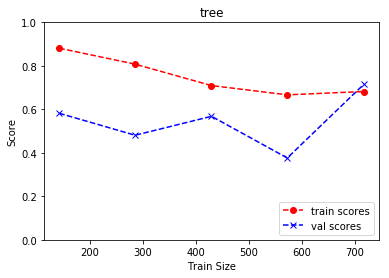

In [32]:
imlearn.draw_learning_curve(train, y_feat='Composer', split_on='Song', clf=grids3['tree'].best_model_, cv=5, omit_mask=omit_mask, random_seed=42, title="tree")

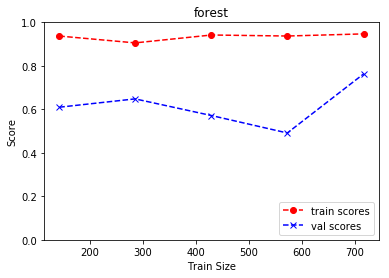

In [33]:
imlearn.draw_learning_curve(train, y_feat='Composer', split_on='Song', clf=grids3['forest'].best_model_, cv=5, omit_mask=omit_mask, random_seed=42, title="forest")

In [34]:
# Combine the audio and MTheory datasets

audio_train = pd.read_pickle('Audio_Feature_train.pkl')
audio_test = pd.read_pickle('Audio_Feature_test.pkl')
audio_test['Composer'].tolist()==test['Composer'].tolist()

True

In [35]:
train_merged = pd.merge(audio_train, train.drop(['Composer','Collection'],axis=1), how='inner', on=['Song','Snippet'])

In [36]:
train_merged.columns

Index(['Composer', 'Collection', 'Song', 'Snippet', 'Tempo', 'SCentr_Range',
       'SContr_mean0', 'SContr_mean1', 'SContr_mean2', 'SContr_mean3',
       'SContr_mean4', 'SContr_mean5', 'SContr_mean6', 'SContr_var0',
       'SContr_var1', 'SContr_var2', 'SContr_var3', 'SContr_var4',
       'SContr_var5', 'SContr_var6', 'Consonance', 'Dissonance', 'Interval_1',
       'Interval_2', 'Interval_3', 'Interval_4', 'Interval_5', 'Interval_6',
       'Mode', 'Perfect', 'Poly_mean', 'Poly_var', 'Tonal_Clarity'],
      dtype='object')

In [110]:
pickle.dump(train_merged,open('train_merged.pkl','wb'))

In [37]:
# Train using CustomGridCV

models = [('svm',svm.SVC),
          ('knn', KNeighborsClassifier), 
          ('logistic', LogisticRegression),
          ('tree', DecisionTreeClassifier),
          ('forest', RandomForestClassifier)
         ]

param_choices = [
    {
        'kernel': ['rbf'],
        'C': np.logspace(-3,3,6),
        'gamma': np.logspace(-3,3,6)
    },
    {
        'n_neighbors': range(1, 12)
    },
    {
        'C': np.logspace(-3,6, 12),
        'penalty': ['l1', 'l2']
    },
    {
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    },
    {
        'n_estimators': [50, 100, 200],
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    }
]

grids = {}
grid_predictions = {}
grid_actuals = {}

for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = imlearn.CustomGridCV(clf=model(), params=params, fold_on='Song')
    grid.fit_score(train_merged, y_feat='Composer', omit_mask=omit_mask, random_seed=42, display=False)
    s = f"{name}: best score: {grid.best_score_}"
    p = f"{name}: best params: {grid.best_parameters_}"
    print(s)
    print(p)
    print()
    grids[name] = grid
    grid_predictions[name],grid_actuals[name] = grid.best_predictions_actuals_

svm: best score: 0.7477080997356842
svm: best params: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}

knn: best score: 0.698530170221185
knn: best params: {'n_neighbors': 1}

logistic: best score: 0.8283004240390393
logistic: best params: {'C': 81.11308307896873, 'penalty': 'l1'}

tree: best score: 0.825669336549242
tree: best params: {'max_depth': 3, 'min_samples_leaf': 10}

forest: best score: 0.8129502308428389
forest: best params: {'max_depth': 5, 'min_samples_leaf': 6, 'n_estimators': 50}



In [38]:
# Train using CustomGridCV

models = [('svm',svm.SVC),
          ('tree', DecisionTreeClassifier),
          ('forest', RandomForestClassifier)
         ]

param_choices = [
    {
        'kernel': ['rbf'],
        'C': np.logspace(2,5,6),
        'gamma': np.logspace(-5,-1,6)
    },
    {
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [10,13,16,20]
    },
    {
        'n_estimators': [25, 50, 100],
        'max_depth': [3,4,5,7,10],
        'min_samples_leaf': [3,6,10]
    }
]

grids2 = {}
grid_predictions = {}
grid_actuals = {}

for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = imlearn.CustomGridCV(clf=model(), params=params, fold_on='Song')
    grid.fit_score(train_merged, y_feat='Composer', omit_mask=omit_mask, random_seed=42, display=False)
    s = f"{name}: best score: {grid.best_score_}"
    p = f"{name}: best params: {grid.best_parameters_}"
    print(s)
    print(p)
    print()
    grids2[name] = grid
    grid_predictions[name],grid_actuals[name] = grid.best_predictions_actuals_

svm: best score: 0.8646864177738154
svm: best params: {'C': 100.0, 'gamma': 1e-05, 'kernel': 'rbf'}

tree: best score: 0.825669336549242
tree: best params: {'max_depth': 3, 'min_samples_leaf': 10}

forest: best score: 0.8505939432314638
forest: best params: {'max_depth': 10, 'min_samples_leaf': 6, 'n_estimators': 25}



In [39]:
# Train using CustomGridCV

models = [('svm',svm.SVC),
          ('knn', KNeighborsClassifier), 
          ('logistic', LogisticRegression),
          ('tree', DecisionTreeClassifier),
          ('forest', RandomForestClassifier)
         ]

param_choices = [
    {
        'kernel': ['rbf'],
        'C': np.linspace(10,1000,10),
        'gamma': np.linspace(1e-06,1e-04,10)
    },
    {
        'n_neighbors': [1]
    },
    {
        'C': np.linspace(10,1000, 10),
        'penalty': ['l1', 'l2']
    },
    {
        'max_depth': [3],
        'min_samples_leaf': [10]
    },
    {
        'n_estimators': [15,20,25,30,35],
        'max_depth': [8,9,10,11,12,15,20],
        'min_samples_leaf': [4,5,6]
    }
]

grids3 = {}
grid_predictions = {}
grid_actuals = {}

for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = imlearn.CustomGridCV(clf=model(), params=params, fold_on='Song')
    grid.fit_score(train_merged, y_feat='Composer', omit_mask=omit_mask, random_seed=42, display=False)
    s = f"{name}: best score: {grid.best_score_}"
    p = f"{name}: best params: {grid.best_parameters_}"
    print(s)
    print(p)
    print()
    grids3[name] = grid
    grid_predictions[name],grid_actuals[name] = grid.best_predictions_actuals_

svm: best score: 0.8666597513799023
svm: best params: {'C': 1000.0, 'gamma': 1e-06, 'kernel': 'rbf'}

knn: best score: 0.698530170221185
knn: best params: {'n_neighbors': 1}

logistic: best score: 0.8282622929595146
logistic: best params: {'C': 450.0, 'penalty': 'l1'}

tree: best score: 0.8236285202227114
tree: best params: {'max_depth': 3, 'min_samples_leaf': 10}

forest: best score: 0.8592777310155618
forest: best params: {'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 25}



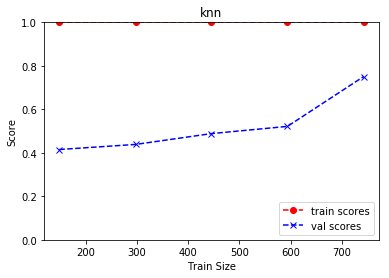

In [40]:
imlearn.draw_learning_curve(train_merged, y_feat='Composer', split_on='Song', clf=grids3['knn'].best_model_, cv=5, omit_mask=omit_mask, random_seed=42, title="knn")

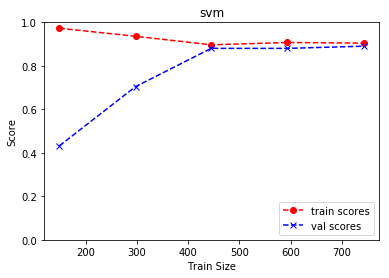

In [41]:
imlearn.draw_learning_curve(train_merged, y_feat='Composer', split_on='Song', clf=grids3['svm'].best_model_, cv=5, omit_mask=omit_mask, random_seed=42, title="svm")

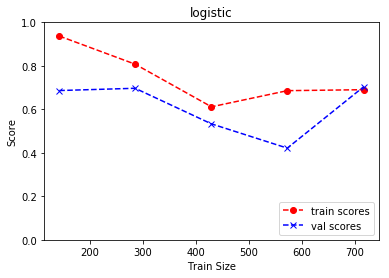

In [42]:
imlearn.draw_learning_curve(train, y_feat='Composer', split_on='Song', clf=grids3['logistic'].best_model_, cv=5, omit_mask=omit_mask, random_seed=42, title="logistic")

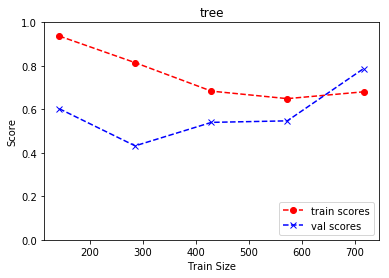

In [43]:
imlearn.draw_learning_curve(train, y_feat='Composer', split_on='Song', clf=grids3['tree'].best_model_, cv=5, omit_mask=omit_mask, random_seed=42, title="tree")

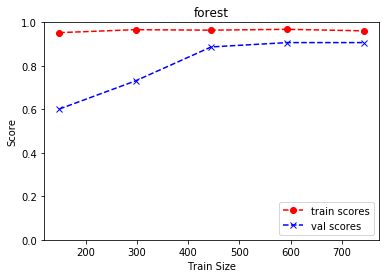

In [44]:
imlearn.draw_learning_curve(train_merged, y_feat='Composer', split_on='Song', clf=grids3['forest'].best_model_, cv=5, omit_mask=omit_mask, random_seed=42, title="forest")

In [45]:
grids3['forest'].best_model_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [80]:
final_pipe = Pipeline([
               ('scaler',StandardScaler()),
               ('forest',grids3['forest'].best_model_)  
])

In [147]:
X_train, y_train = imlearn.X_y_split(train_merged, 'Composer')

In [148]:
final_pipe.fit(X_train.drop(['Collection','Song','Snippet'],axis=1), y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('forest', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
    ...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [149]:
test_merged = pd.merge(audio_test, test.drop(['Composer','Collection'],axis=1), how='inner', on=['Song','Snippet'])

In [150]:
test_merged.columns

Index(['Composer', 'Collection', 'Song', 'Snippet', 'Tempo', 'SCentr_Range',
       'SContr_mean0', 'SContr_mean1', 'SContr_mean2', 'SContr_mean3',
       'SContr_mean4', 'SContr_mean5', 'SContr_mean6', 'SContr_var0',
       'SContr_var1', 'SContr_var2', 'SContr_var3', 'SContr_var4',
       'SContr_var5', 'SContr_var6', 'Consonance', 'Dissonance', 'Interval_1',
       'Interval_2', 'Interval_3', 'Interval_4', 'Interval_5', 'Interval_6',
       'Mode', 'Perfect', 'Poly_mean', 'Poly_var', 'Tonal_Clarity'],
      dtype='object')

In [151]:
train_merged.columns

Index(['Composer', 'Collection', 'Song', 'Snippet', 'Tempo', 'SCentr_Range',
       'SContr_mean0', 'SContr_mean1', 'SContr_mean2', 'SContr_mean3',
       'SContr_mean4', 'SContr_mean5', 'SContr_mean6', 'SContr_var0',
       'SContr_var1', 'SContr_var2', 'SContr_var3', 'SContr_var4',
       'SContr_var5', 'SContr_var6', 'Consonance', 'Dissonance', 'Interval_1',
       'Interval_2', 'Interval_3', 'Interval_4', 'Interval_5', 'Interval_6',
       'Mode', 'Perfect', 'Poly_mean', 'Poly_var', 'Tonal_Clarity'],
      dtype='object')

In [152]:
X_test, y_test = imlearn.X_y_split(test_merged, 'Composer')

In [153]:
test_predictions = final_pipe.predict(X_test.drop(['Collection','Song','Snippet'],axis=1))

In [154]:
final_score = accuracy_score(y_test, test_predictions)

In [155]:
final_score

0.8532338308457711

In [156]:
print(classification_report(y_test, test_predictions))

             precision    recall  f1-score   support

       Bach       0.80      0.92      0.86       196
     Mozart       0.92      0.79      0.85       206

avg / total       0.86      0.85      0.85       402



In [ ]:
model_pipe = Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('tree', DecisionTreeClassifier(max_depth=3,min_samples_leaf=10))
            
])

In [ ]:
X = train.drop(omit_mask+['Composer'],axis=1)
y = train['Composer']
model_pipe.fit(X,y)

In [ ]:
pickle.dump(model_pipe,open('/Users/ilanmoscovitz/github/sf18_ds11/projects/03-mcnulty/flask/model/model.pkl','wb'))

In [ ]:
# Presentation material:

In [99]:
example = mt.get_pickle(examples_path+'example_0.pkl')
example.idee

{'Collection': 'Art_of_Fugue',
 'Composer': 'Bach',
 'Snippet': (1, 5),
 'Song': 'can2'}

In [ ]:
mozart_count = len(df[df['Composer']=='Mozart'])
mozart_count

In [ ]:
bach_count = len(df[df['Composer']=='Bach'])
bach_count

In [ ]:
clarity_df = df[['Composer', 'Tonal_Clarity']].copy()
clarity_df[clarity_df['Composer']=='Bach']['Tonal_Clarity']*=mozart_count/bach_count

poly_df = df[['Composer', 'Poly_mean']].copy()
poly_df[poly_df['Composer']=='Bach']['Poly_mean']*=mozart_count/bach_count

In [ ]:

sns.set(style="whitegrid")
plt.figure(figsize=(10,10))
ax = sns.violinplot(x=clarity_df['Composer'],y=clarity_df['Tonal_Clarity'], hue="Composer",
                    data=clarity_df, palette="muted", split=True)

In [ ]:

sns.set(style="whitegrid")
plt.figure(figsize=(10,10))
ax = sns.violinplot(x=poly_df['Composer'],y=poly_df['Poly_mean'], hue="Composer",
                    data=poly_df, palette="muted", split=True)

In [ ]:
test[test['Collection']=='Art_of_Fugue'][['Song','Collection']]

In [ ]:
# For demonstration, locate the example files for each clip

example_filenames = os.listdir(examples_path)
example_filenames = [example for example in example_filenames if 'example' in example]
examples_index = {}
for example in example_filenames:
    sample = mt.get_pickle(examples_path+example)
    examples_index[example] = sample.idee
examples_index

In [ ]:
# Which features correlate?
train_4_corr = train.copy()
train_4_corr['Composer'] = train_4_corr[['Composer']].applymap(lambda x: 0 if x=='Bach' else 1)

corr = train_4_corr.corr()
corr.sort_values('Composer')

In [ ]:
# Which features correlate?
train_4_corr_merged = train_merged.copy()
train_4_corr_merged['Composer'] = train_4_corr_merged[['Composer']].applymap(lambda x: 0 if x=='Bach' else 1)

corr_merged = train_4_corr_merged.corr()
corr_merged.sort_values('Composer')

In [ ]:
# Best are poly_mean and tonal_clarity (which I guessed Mode only has two discrete values, so 

In [ ]:
inver2_1 = mt.get_pickle(examples_path+'example_62.pkl')
inver2_1.idee

In [ ]:
inver2_2 = mt.get_pickle(examples_path+'example_63.pkl')
inver2_2.idee

In [ ]:
mt.display_chroma(inver2_1.chords);

In [ ]:
df[df['Song']=='mz_279']

In [ ]:
def find_song(songname):
    result = []
    example_filenames = os.listdir(examples_path)
    example_filenames = [example for example in example_filenames if 'example' in example]
    examples_index = {}
    for example in example_filenames:
        sample = mt.get_pickle(examples_path+example)
        song = sample.idee['Song']
        if songname == song:
            result.append(example)
    return result

In [ ]:
find_song('mz_279')

In [ ]:
inver2.display_chords(exaggerate)